<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
#%load_ext autoreload
%matplotlib inline
#%autoreload 2

import sys
from IPython.display import clear_output
# sys.path.append('/eos/user/e/efthymio/Projects/LHCLumi/LHCLumiAnalysis/')
#for p in sys.path:
#    print (p)

import os
import cl2pd
from cl2pd import importData
pd = importData.pd
cals = importData.cals

# import LHCPerformanceTools.LHC_WSData as WSData
# WS = WSData.LHCWSData()

import itertools
import operator
import numpy as np
import glob
import pickle
import gzip
import time

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from scipy.stats.stats import pearsonr 
from itertools import cycle
pd.options.mode.chained_assignment = None  # default='warn'


# get_ipython().magic('matplotlib inline')

# --- Definitions

BASEWSDIR = '/eos/project/l/lhc-profiles-lumi/WS/2018'
RAWWSDIR = '{}/rawdata'.format(BASEWSDIR)
PROCWSDIR = '{}/procdata'.format(BASEWSDIR)

MASS_PROTON = 938.27231 #MeV

# Extract Data and Do Fitting

In [3]:
fno = 6699
fname = '/eos/project/l/lhc-profiles-lumi/WS/2018/procdata/fill_{}/fill_{}_wsprof_exp.pkl'.format(fno, fno)
with open(fname,'rb') as fin:
    scandf = pd.read_pickle(fin)

## Get Timing Properties About the Fill

In [4]:
myFill = importData.LHCFillsByNumber(fno)

t1 = myFill[myFill['mode']=='PRERAMP']['startTime'][0]
t2 = myFill[myFill['mode']=='ADJUST']['endTime'][0]

phases = ['PRERAMP', 'RAMP', 'FLATTOP', 'SQUEEZE', 'ADJUST', 'STABLE']
phase_times = [myFill[myFill['mode']==phase]['startTime'][0] for phase in phases]
myFill

,mode,startTime,endTime,duration
6699,FILL,2018-05-18 18:16:54.156000+00:00,2018-05-18 23:47:19.993000+00:00,05:30:25.837000
6699,INJPROT,2018-05-18 18:17:08.076000+00:00,2018-05-18 18:18:06.216000+00:00,00:00:58.140000
6699,SETUP,2018-05-18 18:18:06.217000+00:00,2018-05-18 18:23:46.679000+00:00,00:05:40.462000
6699,INJPROT,2018-05-18 18:23:46.680000+00:00,2018-05-18 18:27:20.053000+00:00,00:03:33.373000
6699,INJPHYS,2018-05-18 18:27:20.054000+00:00,2018-05-18 18:43:59.837000+00:00,00:16:39.783000
6699,PRERAMP,2018-05-18 18:43:59.838000+00:00,2018-05-18 18:53:28.253000+00:00,00:09:28.415000
6699,RAMP,2018-05-18 18:53:28.254000+00:00,2018-05-18 19:14:17.205000+00:00,00:20:48.951000
6699,FLATTOP,2018-05-18 19:14:17.206000+00:00,2018-05-18 19:59:01.379000+00:00,00:44:44.173000
6699,SQUEEZE,2018-05-18 19:59:01.380000+00:00,2018-05-18 20:11:03.946000+00:00,00:12:02.566000
6699,ADJUST,2018-05-18 20:11:03.947000+00:00,2018-05-18 20:34:29.794000+00:00,00:23:25.847000


## Fit Gaussian Parameters to Get Width

Fit data to

$ f(x) = ae^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma} \right)^2}$

and use $\sigma$ as beam width.

In [5]:
def gaus(x, sigma, x0, a, y0):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + y0

In [6]:
def fit_to_gauss(df_row, wire_movement): #wire movement is "IN" or "OUT:

    x = df_row['PROF_POSITION_'+wire_movement]
    y = df_row['PROF_DATA_'+wire_movement]
    
    # INITIAL GUESSES FOR FIT
    ypeak = max(y) 
    xpeak = x[y.argmax()]
    half_max = np.abs(y-ypeak/2).argmin()
    std_approx = np.abs(x[half_max] - xpeak)
    
    if ypeak>100:
        popt,pcov = scipy.optimize.curve_fit(gaus,x,y,p0=[std_approx, xpeak, ypeak, 0])
        sigma, mean, ampl, yoff = popt 
    else:
        mean = ampl = yoff = 0
        sigma = None
        
    return sigma

In [7]:
scandf['BEAM_WIDTH_IN'] = scandf.apply(fit_to_gauss, axis='columns', args=('IN',))
scandf['BEAM_WIDTH_OUT'] = scandf.apply(fit_to_gauss, axis='columns', args=('OUT',))

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Set Appropriate Beta Values

Given by Dr. Efthymiopoulos

In [8]:
def get_beta(df_row):
    
    BEAM_NUM = str(df_row['BEAM'])
    POS = str(df_row['PLANE'])
    
    if BEAM_NUM == 'B1' and POS == 'V':
        inj_beta, flattop_beta, squeeze_beta = 342.1, 337.5, 333.4
    if BEAM_NUM == 'B1' and POS == 'H':
        inj_beta, flattop_beta, squeeze_beta = 193.4, 183.3, 193.2
    if BEAM_NUM == 'B2' and POS == 'V':
        inj_beta, flattop_beta, squeeze_beta = 396.6, 421.1, 408.3
    if BEAM_NUM == 'B2' and POS == 'H':
        inj_beta, flattop_beta, squeeze_beta = 185.3, 187.7, 182.3
        
    if df_row.name>=phase_times[0] and df_row.name<=phase_times[3]:
        BETA = inj_beta
    elif df_row.name>=phase_times[3] and df_row.name<=phase_times[4]:
        BETA = flattop_beta
    elif df_row.name>=phase_times[4]:
        BETA = squeeze_beta
    else:
        BETA = None
    
    return BETA 

In [9]:
scandf['BETA'] = scandf.apply(get_beta, axis='columns')
scandf = scandf.dropna()

## Set Appropriate Emittance Values

$\epsilon_N = \frac{E}{m}\frac{\sigma^2}{\beta}$

In [10]:
def get_emit(df_row, wire_movement):
    return (df_row['BEAM_WIDTH_'+wire_movement]**2 *
            (df_row['ENERGY']) /
            (df_row['BETA'] * MASS_PROTON))*10**-3

In [11]:
scandf['EMIT_IN'] = scandf.apply(get_emit, axis='columns', args=('IN',))
scandf['EMIT_OUT'] = scandf.apply(get_emit, axis='columns', args=('OUT',))

## Set Appropriate Brightness Values

$B=\frac{\epsilon_N}{I}$

In [12]:
def get_bright(df_row, wire_movement):
    return df_row['EMIT_'+wire_movement]/df_row['INTENSITY']

In [13]:
scandf['BRIGHT_IN'] = scandf.apply(get_bright, axis='columns', args=('IN',))
scandf['BRIGHT_OUT'] = scandf.apply(get_bright, axis='columns', args=('OUT',))

# Plotting

## Emittance Throughout All Time

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/seaborn/categorical.py:885: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/seaborn/categorical.py:905: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


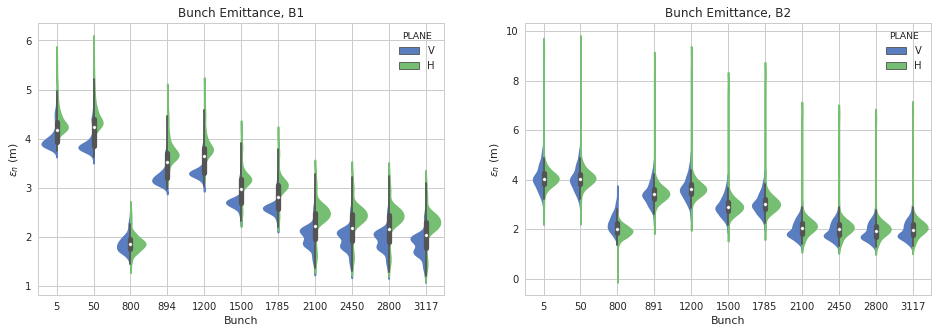

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,5))
sns.violinplot(x='BUNCH', y='EMIT_IN', hue='PLANE',
                  data=scandf[scandf['BEAM']=='B1'], palette="muted", split=True, ax=axes[0])
props = {'title': 'Bunch Emittance, B1', 'xlabel': 'Bunch',
        'ylabel': r"$\epsilon_{n}$ (m)"}
axes[0].set(**props)
axes[0].grid()

sns.violinplot(x='BUNCH', y='EMIT_IN', hue='PLANE',
                  data=scandf[scandf['BEAM']=='B2'], palette="muted", split=True, ax=axes[1])
props = {'title': 'Bunch Emittance, B2', 'xlabel': 'Bunch',
        'ylabel': r"$\epsilon_{n}$ (m)"}
axes[1].set(**props)
axes[1].grid()

fig.savefig('violinplotbunches.pdf', bbox_inches='tight')
plt.show()

Theoretically, the conservation of $\epsilon_N$ should enforce that each histogram resemble a dirac delta function: these plots show that this is not the case.

## Preramp and Ramp Plot 

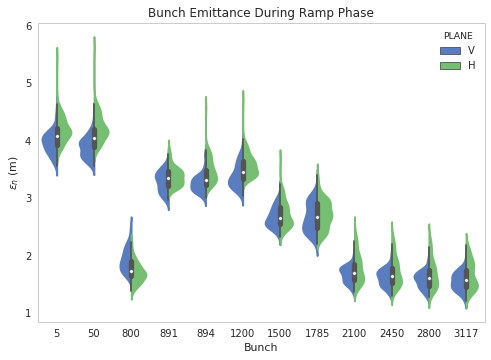

In [15]:
t1 = phase_times[0] #PRERAMP
t2 = phase_times[2] #FLATTOP
fig, ax = plt.subplots()
sns.violinplot(x='BUNCH', y='EMIT_IN', hue='PLANE',
                  data=scandf[(scandf.index >= t1) & (scandf.index <= t2)],
                  palette="muted", split=True, ax=ax)
props = {'title': 'Bunch Emittance During Ramp Phase', 'xlabel': 'Bunch',
        'ylabel': r"$\epsilon_{n}$ (m)"}
ax.set(**props)
plt.show()